# Yet Another NY Taxi demo

In this notebook, we'll set up a connection to IRIS and walk through a few exciting query results showcasing advances in IRIS SQL throughout 2022.1 and 2022.2. First, we're using IRIS DB-API to set up a connection to IRIS.

In [25]:
import iris, time, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# replace this with your connection info as needed
hostname = os.getenv("ISC_TAXI_HOSTNAME")
hostname = "host.docker.internal"
port = os.getenv("ISC_TAXI_PORT")
port = 12772
namespace = os.getenv("ISC_TAXI_NAMESPACE")
namespace = "IRISAPP"
user = os.getenv("ISC_TAXI_USER")
user = "_system"
pwd = os.getenv("ISC_TAXI_PASSWORD")
pwd = "SYS"

connection = iris.connect(str(hostname)+":"+str(port)+"/"+str(namespace), user, pwd)
print("connected to",connection.hostname,"on namespace",connection.namespace,not connection.isClosed())

connected to host.docker.internal on namespace IRISAPP True


The following utility paragraph just suppresses usage warnings for pandas preferring SQLAlchemy over DB-API 

In [26]:
import warnings
warnings.simplefilter("ignore")

Now we'll set up a few utility functions we'll be using throughout the demo

In [27]:
# utility vars and function to compare metrics
last_time = 0
last_grefs = 0
plans = []

def reset_compare():
    global last_time, last_grefs
    last_time = 0
    last_grefs = 0

def brag(prev, new, speed=True):
    if ((prev == 0) or (new == 0) or (prev == new)):
        return ""
    if (prev > new):
        rate = prev / new
        if (rate > 2):
            return " - {:,.2f}x {}".format(rate, "faster" if speed else "less")
        else:
            return " - {:,.0%} {}".format(rate-1, "faster" if speed else "less")
    else:
        rate = new / prev
        if (rate > 2):
            return " - {:,.2f}x {}".format(rate, "slower" if speed else "more")
        else:
            return " - {:,.0%} {}".format(rate-1, "slower" if speed else "more")

def just_sql(sql):
    c1 = connection.cursor()
    c1.execute(sql)
    result = c1.fetchall()[0][0]
    c1.close()
    return result  

def query(sql, compare = False, dtypes = None):
    global last_time, last_grefs, plans
    
    plans.append(just_sql("EXPLAIN "+sql))
    
    start_grefs = just_sql("SELECT NYTaxi.GloRefs()")
    
    start_time = time.time()
    result = pd.read_sql_query(sql, connection, dtype = dtypes)
    exec_time = time.time() - start_time
    
    exec_grefs = just_sql("SELECT NYTaxi.GloRefs()") - start_grefs - 1
    
    if compare:
        print("\nExecution time: "+str(round(exec_time,3))+"s " + brag(last_time, exec_time))
        print("Global references: "+str(exec_grefs)+" "+ brag(last_grefs, exec_grefs, False))
        last_time = exec_time
        last_grefs = exec_grefs
    else:
        print("\nExecution time: "+str(round(exec_time,3))+"s \nGlobal references: "+str(exec_grefs))
    
    return result


## A first test to validate the connection


Execution time: 0.007s 
Global references: 14


IndexError: index 0 is out of bounds for axis 0 with size 0

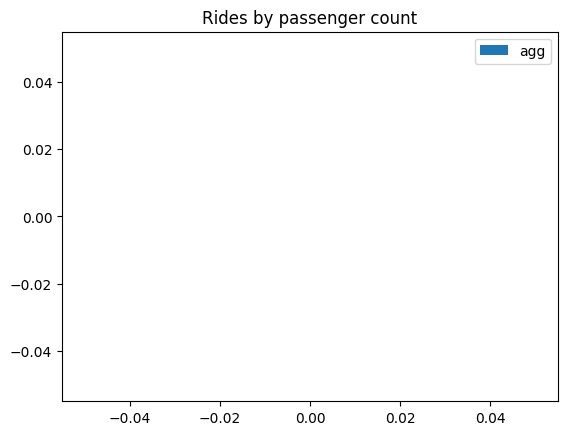

In [28]:
r = query("SELECT passenger_count AS pg, COUNT(*) AS agg "+
          "FROM NYTaxi.Rides "+
          "GROUP BY passenger_count", dtypes = { 'agg': np.int64 })

r.plot.barh(x='pg',y='agg',title="Rides by passenger count");

## Adaptive Mode in SQL

Adaptive Mode includes RunTime PlanChoice, which we can disable for the sake of the demo by using `#NORUNTIME`

In [29]:
r = query("SELECT %NORUNTIME AVG(total_amount) "+
             "FROM NYTaxi.RowRides "+
             "WHERE passenger_count > 3 "+
                   "AND tpep_pickup_datetime BETWEEN '2020-01-01' AND '2021-12-31'", True)


Execution time: 0.032s 
Global references: 6336 


Luckily it's ON by default, so we can just leave out that hint and get great out-of-the-box performance.

In [30]:
r = query("SELECT AVG(total_amount) "+
             "FROM NYTaxi.RowRides "+
             "WHERE passenger_count > 3 "+
                   "AND tpep_pickup_datetime BETWEEN '2020-01-01' AND '2021-12-31'", True)


Execution time: 0.03s  - 8% faster
Global references: 6493  - 2% more


The above speedup is realized by making proper use of advanced statistics collected by IRIS in 2022.1. In this particular case, we're relying on histograms that capture how our field values are distributed across rows. The chart below shows this information for the `tpep_pickup_datetime` field. 
As you'll note, almost all of the data is in our requested date range, so using the index on this supposedly selective field is not very helpful for this set of runtime parameters.

In [31]:
r = query("SELECT MonthYear, SUM(sample) As RowCount FROM (select $PIECE(CAST(CAST(tpep_pickup_datetime AS POSIXTIME) AS VARCHAR),'-',1,2) AS MonthYear, 10000 AS sample FROM %PARALLEL NYTaxi.RowRides WHERE (%ID # 10000)=0) GROUP BY MonthYear")
r.plot.bar(x='MonthYear', y='RowCount');


Execution time: 0.03s 
Global references: 6653


TypeError: no numeric data to plot

# Columnar Storage

Now let's run the very same query again, now targeting the columnar version of our table. 
Note the different table name in the `FROM` clause.

In [32]:
r = query("SELECT AVG(total_amount) "+
             "FROM NYTaxi.Rides "+
             "WHERE passenger_count > 2 "+
                   "AND tpep_pickup_datetime BETWEEN '2020-01-01' AND '2020-12-31'")


Execution time: 0.038s 
Global references: 7918


In [33]:
print(plans[-1])

<plans>
 <plan>
 <sql>
  SELECT AVG ( total_amount ) FROM NYTaxi . Rides WHERE passenger_count > ? AND tpep_pickup_datetime BETWEEN ? AND ? /*#OPTIONS {"xDBCIsoLevel":"0"} */ /*#OPTIONS {"DynamicSQLTypeList":"10,1,1"} */
 </sql>
 <cost value=""/>
 Call module C.
 Output the row.
 <module name="C" top="1">
 Read extent bitmap NYTaxi.Rides.%%DDLBEIndex, looping on bitmap chunks.
 For each bitmap chunk:
     Read columnar index NYTaxi.Rides._CDM_passengercount, using the given chunk number.
     Apply vector operation > to produce a filter.
     Read columnar index NYTaxi.Rides._CDM_tpeppickupdatetime, using the given chunk number.
     Apply vector and bitmap operations >=, & with a >= condition on tpep_pickup_datetime, <=, & with a <= condition on tpep_pickup_datetime, defined on tpep_pickup_datetime, and & with a NOT NULL condition on tpep_pickup_datetime to produce a filter.
     Read columnar index NYTaxi.Rides._CDM_totalamount, using the given chunk number.
     Apply vector operati

That was just to show off, now let's look at some more decent examples

This query shows how far along we got in teaching the IRIS SQL engine to work with columnar storage. There's groupings, aggregates, order by and an outer JOIN!


Execution time: 0.044s 
Global references: 8850


IndexError: index 0 is out of bounds for axis 0 with size 0

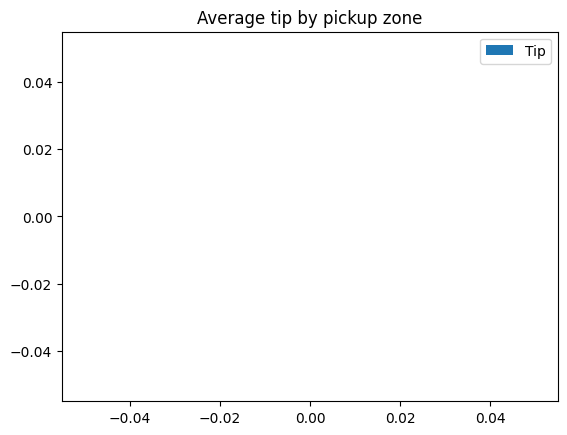

In [34]:
reset_compare()
r = query("SELECT Zone, Borough, Tip FROM ("+
              "SELECT TOP 10 PULocationID, AVG(tip_amount / fare_amount) AS Tip "+
              "FROM NYTaxi.RowRides "+
              "WHERE fare_amount > 0 "+
              "GROUP BY PULocationID "+
              "ORDER BY 2 DESC"+
          ") r LEFT JOIN NYTaxi.Zones z ON r.PULocationID = z.LocationID", 
          dtypes = { "Tip": np.double })

r.plot.barh(x="Zone", y="Tip", title="Average tip by pickup zone");


Execution time: 0.031s 
Global references: 10548


IndexError: index 0 is out of bounds for axis 0 with size 0

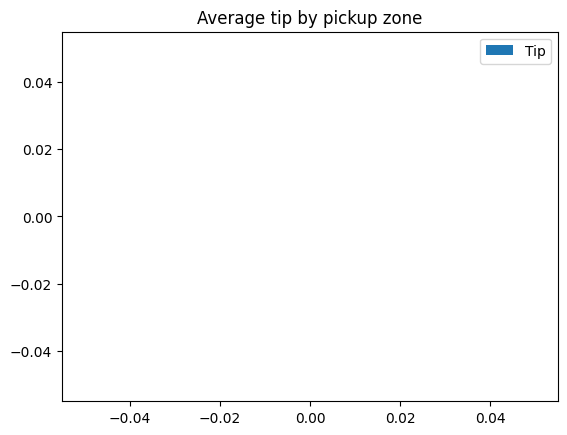

In [35]:
r = query("SELECT Zone, Borough, Tip FROM ("+
              "SELECT TOP 10 PULocationID, AVG(tip_amount / fare_amount) Tip "+
              "FROM NYTaxi.Rides "+
              "WHERE fare_amount > 0 "+
              "GROUP BY PULocationID "+
              "ORDER BY 2 DESC"+
          ") r LEFT JOIN NYTaxi.Zones z ON r.PULocationID = z.LocationID", 
          dtypes = { "Tip": np.double })

r.plot.barh(x="Zone", y="Tip", title="Average tip by pickup zone");

In [36]:
print(plans[-1])

<plans>
 <plan>
 <sql>
  SELECT Zone , Borough , Tip FROM ( SELECT TOP ? PULocationID , AVG ( tip_amount / fare_amount ) Tip FROM NYTaxi . Rides WHERE fare_amount > ? GROUP BY PULocationID ORDER BY 2 DESC ) r LEFT JOIN NYTaxi . Zones z ON r . PULocationID = z . LocationID /*#OPTIONS {"xDBCIsoLevel":"0"} */ /*#OPTIONS {"DynamicSQLTypeList":"10,10"} */
 </sql>
 <cost value="103000"/>
 Call module H, which populates temp-file A.
 Read temp-file A, looping on AVG and a counter.
 For each row:
     Read index map NYTaxi.Zones(Z).LocationID, using the given Z.LocationID, and getting Z.ID.
     Read master map NYTaxi.Zones(Z).IDKEY, using the given idkey value.
     Test the NOT NULL condition on Z.LocationID.
     Generate a row padded with NULL for table NYTaxi.Zones if no row qualified.
     Output the row.
 <module name="H" top="1">
 Call module I.
 Read array temp-file B, looping on PULocationID.
 For each row:
     Read array temp-file C, using the given subscript values.
     Read arra

The following query does some basic data quality style checking and would make sense to someone evaluating the data, but not at all be something your DBA would create an index for. It's an illustration of the _conversation_ you can have with big tables thanks to columnar storage.

In [37]:
reset_compare()
query("SELECT COUNT(*) AS TimeTravel "+
      "FROM NYTaxi.RowRides "+
      "WHERE tpep_pickup_datetime > tpep_dropoff_datetime")


Execution time: 0.021s 
Global references: 5663


,TimeTravel
0,0


In [38]:
query("SELECT COUNT(*) AS TimeTravel "+
      "FROM NYTaxi.Rides "+
      "WHERE tpep_pickup_datetime > tpep_dropoff_datetime")


Execution time: 0.026s 
Global references: 7191


,TimeTravel
0,0


And now it's time to boast with some more spectacular differences

In [39]:
reset_compare()
r = query("SELECT AVG(fare_amount), AVG(tip_amount) "+
          "FROM NYTaxi.RowRides "+
          "WHERE payment_type = 1")

r.plot.bar(stacked=True, title="Average fare vs tip");


Execution time: 0.028s 
Global references: 6436


TypeError: no numeric data to plot

In [40]:
r = query("SELECT AVG(fare_amount) AS \"Average fare\", AVG(tip_amount) AS \"Average tip\" "+
          "FROM NYTaxi.Rides "+
          "WHERE payment_type = 1")

r.plot.bar(stacked=True, title="Average fare vs tip");


Execution time: 0.028s 
Global references: 8112


TypeError: no numeric data to plot